In [27]:
from dotenv import load_dotenv
import os

load_dotenv()
os.environ["LANGCHAIN_PROJECT"] = "Real World Challenge_LP SOLVER"

print("LangSmith 설정이 완료되었습니다.")
print(f"현재 프로젝트: {os.getenv('LANGCHAIN_PROJECT')}")

LangSmith 설정이 완료되었습니다.
현재 프로젝트: Real World Challenge_LP SOLVER



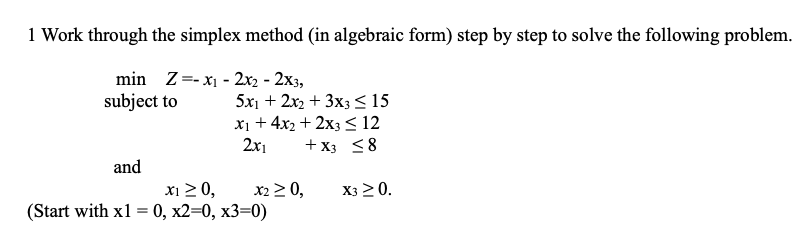

minimize Z = -x_1 - 2x_2 - 2x_3

subject to
5x_1 + 2x_2 + 3x_3 <= 15
x_1 + 4x_2 + 2x_3 <= 12
2x_1 + x_3 <= 8

x_1 >= 0, x_2 >= 0, x_3 >= 0

(Start with x_1 = 0, x_2 = 0, x_3 = 0)


In [28]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_teddynote.models import MultiModal

image_to_code = ChatOpenAI(
    temperature = 0, #0에 가까울 수록 정제된, 2에 가까울 수록 창의적인
    model_name = "gpt-4o" #사용할 OpenAI 모델을 지정
)

systemprompt = """
    LP 과목의 이해를 돕는 조교야. 주어진 LP 문제 이미지 혹은 문제의 상황을 형식에 맞게 글로 다시 적어줘.
    형식에 대한 예시도 줄게. 예시처럼 적어줘.

    예시 :
    maximize 3x_1 + 2x_2
    subject to
    x_1 + 2x_2 <= 4
    x_1 + x_2 <= 2
    x_1, x_2 >= 0
    
    """    
userprompt = """
        다음의 문제상황 혹은 LP 문제 이미지를 해당하는 형식에 맞게 LP Formulation 해줘. 
        분, 시간 단위에 유의해서 분으로 단위를 통일해서 적어줘.
        금액은 만원이 아니라 원 단위로 적어줘.
        LaTeX 코드 형식으로 말고 일반 텍스트 형식으로 출력해줘.
        """
#질문 내용
#LP 문제 이미지를 형식에 맞게 글로 다시 적어줘.

multimodal_llm_with_prompt = MultiModal(image_to_code, system_prompt = systemprompt, user_prompt = userprompt)
#위와 달리 multimodal에게 프롬프트를 같이 준다

IMAGE_PATH_FROM_FILE = "/Users/user/Desktop/Real World Challenge/Example Set/LP23.png"
math = multimodal_llm_with_prompt.invoke(IMAGE_PATH_FROM_FILE)

print(math)

In [29]:
math_to_code = ChatOpenAI(model="gpt-4o-mini", temperature=0)
prompt = PromptTemplate.from_template(
    """
    {problem}을 SciPy 라이브러리의 optimize 모듈의 linprog 함수를 사용해서 풀 수 있도록 코드를 만들어.
    문제를 풀기 전에 목점함수가 min문제면 i=0, max문제면 i=1로 값을 할당해줘.
    또 제약 부등식을 코드에 넣기 전에 상수가 있는 우변이 더 크게 가르키도록 변형하고 코드에 넣어줘. 
    그리고 마지막 결과값을 출력할 때 i==0이면 그냥 출력하고, i==1이면 Objective value에 -1을 곱해서 출력해.

    제약 부등식을 부등호의 방향을 기준으로 먼저 구분하여 주석을 작성해.
    그리고 부등호의 방향이 >= 인 것이 있으면 양 변에 -1 을 곱해서 식을 재구성하여
    수정된 제약식을 다시 주석으로 작성해.
    그 뒤에 그 수정된 제약식을 바탕으로 matrix를 알맞게 만들어줘.

    그리고 Optimal Solution도 출력해줘.
    바로 실행할 수 있도록 코드만 적어줘.

    결과 출력은 아래의 형태로 해줘.

    If the solution is infeasible, then print out with 'print("It is infeasible")'.
    If the solution is unbounded, then print out with 'print("It is unbounded")'.
    """
    )
chain = prompt | math_to_code | StrOutputParser()

code = chain.invoke(
    {"problem": math})

print(code)

```python
import numpy as np
from scipy.optimize import linprog

# Objective function: minimize Z = -x_1 - 2x_2 - 2x_3
# Since it's a minimization problem, set i = 0
i = 0
c = [-1, -2, -2]  # Coefficients for the objective function

# Constraints
# Original constraints:
# 5x_1 + 2x_2 + 3x_3 <= 15
# x_1 + 4x_2 + 2x_3 <= 12
# 2x_1 + x_3 <= 8

# All constraints are <=, so we can use them as is
A = [
    [5, 2, 3],
    [1, 4, 2],
    [2, 0, 1]
]
b = [15, 12, 8]

# Solve the linear programming problem
result = linprog(c, A_ub=A, b_ub=b, bounds=(0, None))

# Check the result
if result.success:
    if i == 0:
        print("Objective value:", result.fun)
    else:
        print("Objective value:", -result.fun)
    print("Optimal Solution:", result.x)
else:
    if result.status == 2:
        print("It is infeasible")
    elif result.status == 3:
        print("It is unbounded")
```


In [30]:
from langchain_experimental.tools import PythonREPLTool
from langchain_core.runnables import RunnableLambda
from langchain.tools import tool
from typing import List, Dict, Annotated
from langchain_experimental.utilities import PythonREPL

@tool()
def python_repl_tool(code : Annotated[str, "The python code to execute to generate outputs"]):
    """ use this to execute python code.
    If you want to see the output of a value, you should print it out with 'print(...)'
    This is visible to use the user
    """
    result = ""
    try:
        python_tool = PythonREPLTool()
        return python_tool.invoke(code)
    except BaseException as e:
        print("Failed to execute.", e)
    finally:
        return result
    

py_tool = PythonREPLTool()

print(py_tool.invoke(code))

Objective value: -10.5
Optimal Solution: [0.   0.75 4.5 ]

